In [1]:
import re
import os
import sys
import time
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
from numpy.linalg import *
from scipy.linalg import *
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *

np.set_printoptions(linewidth=200)

rho norm: 0.00076547501441264930
rho fidelity: 0.99997400919308354617


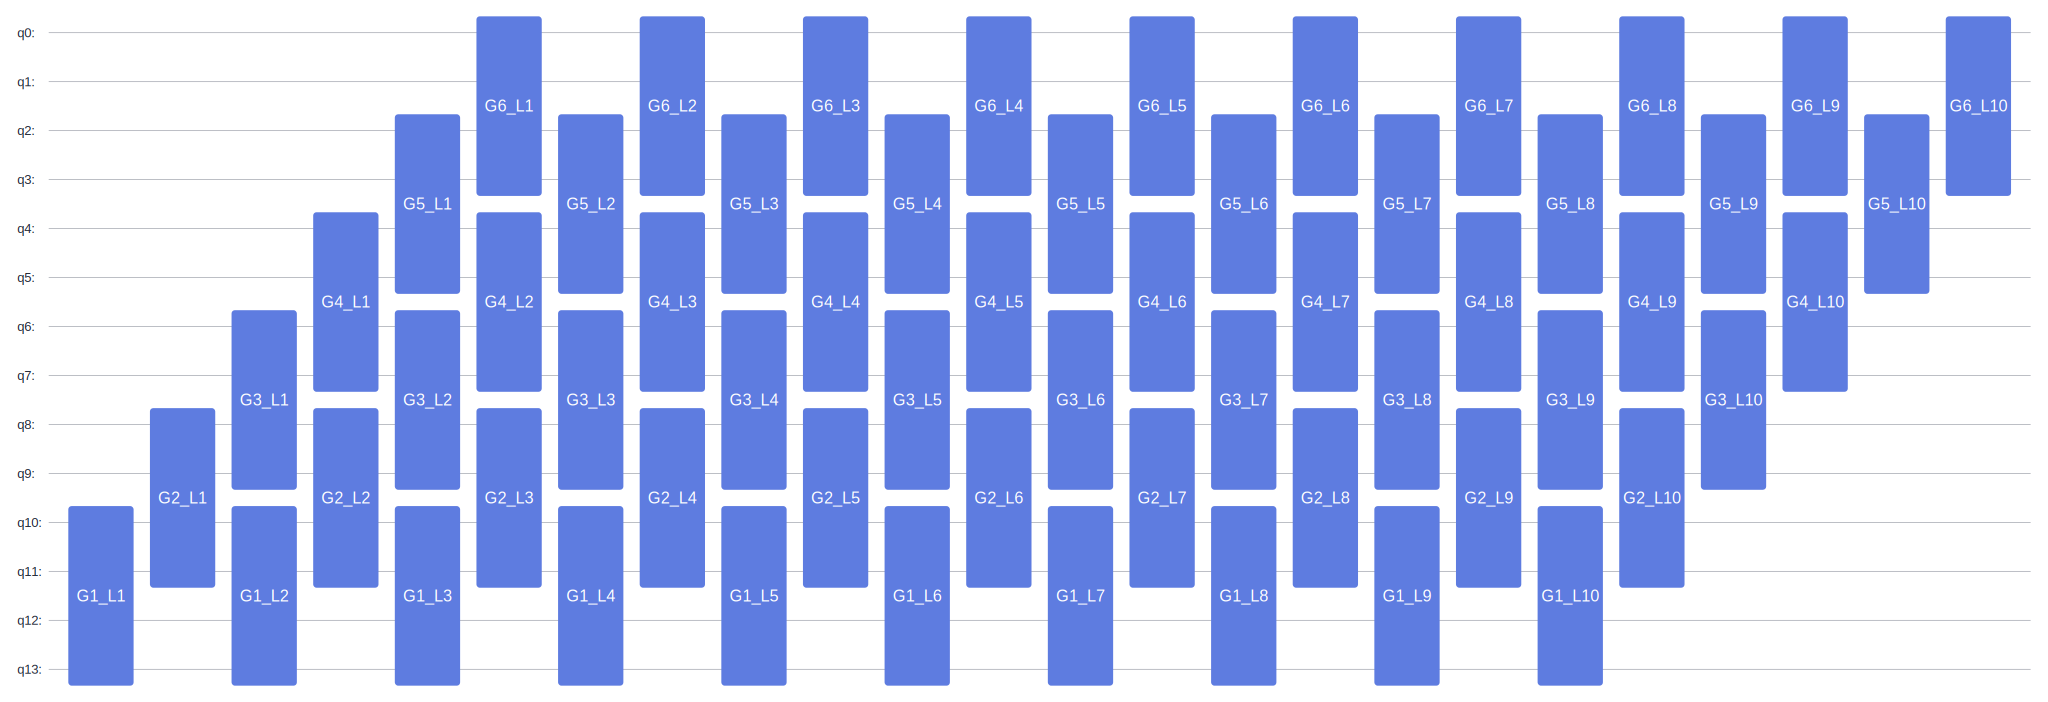

In [2]:
g = File('./mat/322_d3_num1_model957_RDM3_gates_L10_N7_variational.mat', 'r')
position = g['RDM_site'][:] - 1  # subtract index of matlab to python
l = list(g.keys())  # list of HDF5 gates file keys
d = int(g['d'][0])  # dimension of qudit state
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
# print(position, g_name)
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

r = File('./mat/322_d3_num1_model957_RDM_v7.3.mat', 'r')
l = list(r.keys())  # list of HDF5 rdm file keys
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

pr = {}
circ = Circuit()
ansatz = Circuit()
nq = (k + 1) * (d - 1)
Id = su2_encoding(np.eye(d**2), 2)
p = np.eye(Id.shape[0]) - Id
for i in range(len(g_name)):
    for j in range(k):
        name = f'G{j + 1}_L{i + 1}'
        mat = su2_encoding(gates[i][j], 2) + p
        obj = list(range(nq - (d - 1) * (j + 2), nq - (d - 1) * j))
        circ += UnivMathGate(name, mat).on(obj)

sim = Simulator('mqvector', nq)
sim.apply_circuit(circ)
psi = sim.get_qs()

psi = su2_decoding(psi, k + 1)
rho_rdm = reduced_density_matrix(psi, d, position)
print('rho norm: %.20f' % norm(rdm[3] - rho_rdm, 2))
print('rho fidelity: %.20f' % fidelity(rdm[3], rho_rdm))

circ.svg()

Number of qubits: 9
Number of params: 1280
Number of gates: 1360
Hamiltonian Dimension: (512, 512)
rho norm: 0.00036726646838604787
rho fidelity: 0.99999936973635861204


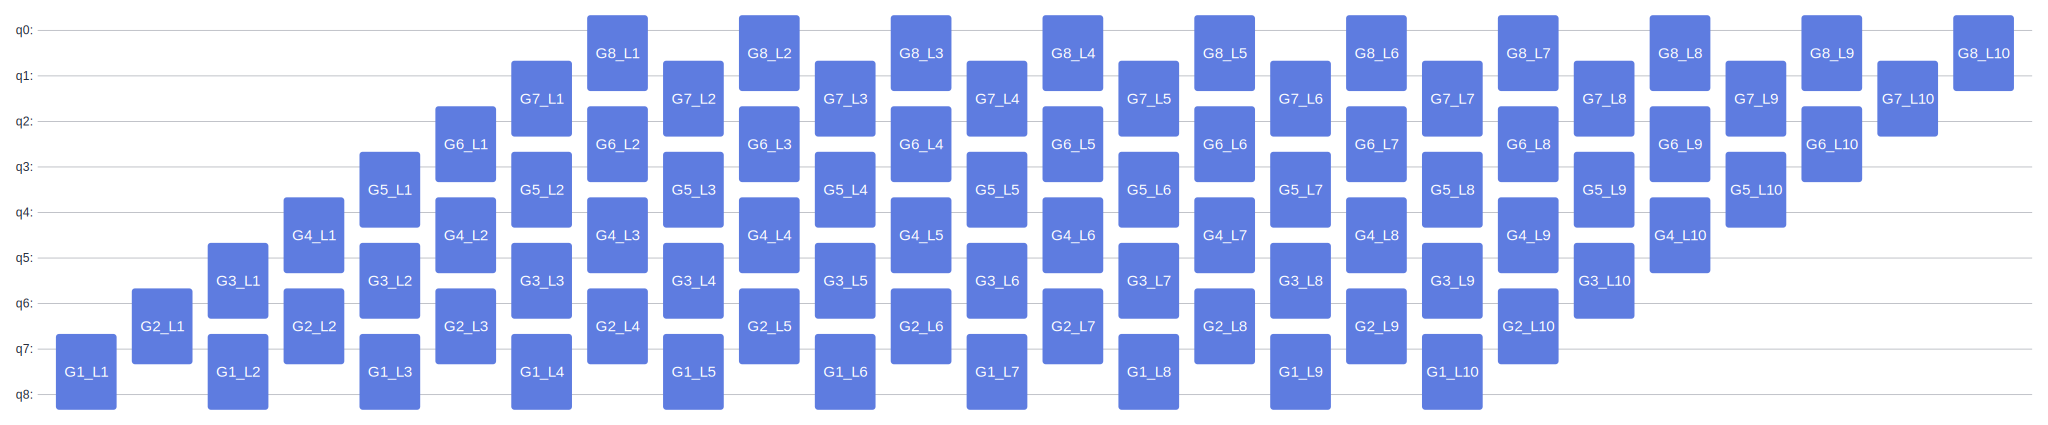

In [3]:
g = File('./mat/322_d2_num1_model957_RDM3_gates_L10_N9_variational.mat', 'r')
position = g['RDM_site'][:] - 1  # subtract index of matlab to python
l = list(g.keys())  # list of HDF5 gates file keys
d = int(g['d'][0])  # dimension of qudit state
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
# print(position, g_name)
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

r = File('./mat/322_d2_num1_model957_RDM_v7.3.mat', 'r')
l = list(r.keys())  # list of HDF5 rdm file keys
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

pr = {}
circ = Circuit()
ansatz = Circuit()
for i in range(len(g_name)):
    for j in range(k):
        name = f'G{j + 1}_L{i + 1}'
        mat = gates[i][j]
        gate_u = UnivMathGate(name, mat).on([k - j - 1, k - j])
        gate_d, para = two_qubit_decompose(gate_u)
        pr.update(para)
        circ += gate_u
        ansatz += gate_d

nq = ansatz.n_qubits
p_name = ansatz.ansatz_params_name
pr = {i: pr[i] for i in p_name}
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim = Simulator('mqvector', nq)
sim.apply_circuit(circ)
psi = sim.get_qs()

rho = np.outer(psi, psi.conj())
print('Hamiltonian Dimension:', rho.shape)
Ham = Hamiltonian(csr_matrix(rho))

rho_rdm = reduced_density_matrix(psi, d, position)
print('rho norm: %.20f' % norm(rdm[3] - rho_rdm, 2))
print('rho fidelity: %.20f' % fidelity(rdm[3], rho_rdm))

circ.svg()

In [ ]:
g = File('./mat/322_d2_num1_model957_site3_gates_L39_N9_zhu(2).mat', 'r')
# position = g['position'][:] - 1  # subtract index of matlab to python
position = [3, 4, 5]
l = list(g.keys())  # list of HDF5 file keys
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
# print(position, g_name)
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

r = File('./mat/322_d2_num1_model957_RDM_v7.3.mat', 'r')
l = list(r.keys())
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

In [ ]:
pr = {}
circ_u = Circuit()
circ_d = Circuit()
for i in range(len(g_name)):
    for j in range(k):
        gate_name = f'G{j + 1}_L{i + 1}'
        gate_mat = gates[i][j]
        if j == k - 1:
            gate_u = UnivMathGate(gate_name, gate_mat).on(k - j - 1)
            gate_d, para = one_qubit_decompose(gate_u)
            pr.update(para)
            circ_u += gate_u
            circ_d += gate_d
        else:
            gate_u = UnivMathGate(gate_name, gate_mat).on([k - j - 2, k - j - 1])
            gate_d, para = two_qubit_decompose(gate_u)
            pr.update(para)
            circ_u += gate_u
            circ_d += gate_d

circ_u.summary()
circ_d.summary()

sim_u = Simulator('mqvector', k)
sim_d = Simulator('mqvector', k)
sim_u.apply_circuit(circ_u)
sim_d.apply_circuit(circ_d.apply_value(pr))
psi_u = sim_u.get_qs()
psi_d = sim_d.get_qs()
rho_u = np.outer(psi_u, psi_u.conj())
rho_d = np.outer(psi_d, psi_d.conj())

print('circ norm: %.20f' % norm(circ_u.matrix() - circ_d.matrix(pr)))
print('psi norm: %.20f, fidelity: %.20f' % (norm(psi_u - psi_d, 2), fidelity(psi_u, psi_d)))
print('rho norm: %.20f, fidelity: %.20f' % (norm(rho_u - rho_d, 2), fidelity(rho_u, rho_d)))

rho = reduced_density_matrix(rho_u, position)
print('rdm[3] norm: %.20f, fidelity: %.20f' % (norm(rdm[3] - rho, 2), fidelity(rdm[3], rho)))

========Circuit Summary========
|Total number of gates  : 351.|
|Parameter gates        : 0.  |
|with 0 parameters are  :     |
|                        .    |
|Number qubit of circuit: 9   |
==========================================================================Circuit Summary==========================================================================
|Total number of gates   : 5460.                                                                                                                                  |
|Parameter gates         : 5460.                                                                                                                                  |
|with 5148 parameters are:                                                                                                                                        |
|G1_L1_B0_lam, G1_L1_B0_theta, G1_L1_B0_phi, G1_L1_B1_lam, G1_L1_B1_theta, G1_L1_B1_phi, G1_L1_Rxx, G1_L1_Ryy, G1_L1_Rzz, G1_L1_phase..                 

In [ ]:
ham = np.kron(np.kron(rdm[3], rdm[3]), rdm[3])
Ham = Hamiltonian(csr_matrix(ham))

ansatz = circ_d.apply_value(pr)
sim = Simulator('mqvector', ansatz.n_qubits)
sim.apply_circuit(ansatz)

print(sim.get_expectation(Ham, ansatz))
sim.get_expectation_with_grad(Ham, ansatz)

(0.3030279073981368+8.364951753784262e-17j)


True True
rho trace: 0.99999999999999400480
rho^2 trace: 0.76640206516669173720
0.9999990718069235 0.0004388447506908427


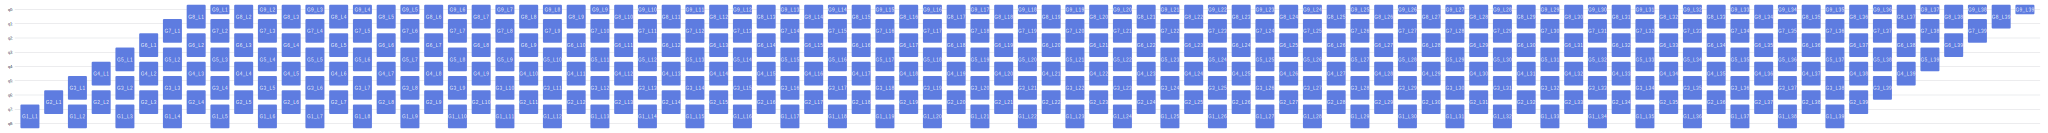

In [ ]:
circ = Circuit()
mat = np.eye(2**k)
for i in range(len(g_name)):
    for j in range(k):
        gate_name = f'G{j + 1}_L{i + 1}'
        gate_mat = gates[i][j]
        if j == k - 1:
            circ += UnivMathGate(gate_name, gate_mat).on(k - j - 1)
            temp = np.kron(np.eye(2**j), gate_mat)
        else:
            circ += UnivMathGate(gate_name, gate_mat).on([k - j - 2, k - j - 1])
            temp = np.kron(np.eye(2**j), np.kron(gate_mat, np.eye(2**(k - j - 2))))
        mat = mat @ temp.conj().T

sim = Simulator('mqvector', k)
psi0 = sim.get_qs()
sim.apply_circuit(circ)
psi = sim.get_qs()
rho = np.outer(psi, psi.conj())
print(np.allclose(psi, (psi0 @ mat).conj()), np.allclose(mat.conj().T, circ.matrix()))

rho = reduced_density_matrix(rho, position)
# # print(rho, rho.shape)
print('rho trace: %.20f' % np.real(np.trace(rho)))
print('rho^2 trace: %.20f' % np.real(np.trace(rho @ rho)))
print(fidelity(rdm[3], rho), norm(rdm[3] - rho, 2))

circ.svg()